In [1]:
"""LiuKatrina_13.ipynb Harvard MCB 112 Problem Set 13: the Moriarty Brain Atlas submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Dec 10, 2022"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.optimize import bisect
from scipy import optimize

In [3]:
def read_table(file):
    """
    Read the file and parse them into variables and types
    """
    data = pd.read_csv(file,delim_whitespace=True)
    data_param = data.iloc[:,:-1]
    data_type = data.iloc[:,-1]
    return np.log(np.add(1,data_param.to_numpy())), data_type

# Code adopted from mcb112.org
def visualize_data(data,C, PC=False):
    '''
    visualize_data():
    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = [ 'xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue',
          'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
          'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
          'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy' ]

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.plot( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    
    if PC == True:
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
    else:
        ax.set_xlabel('TSNE1')
        ax.set_ylabel('TSNE2')
    fig.show()


# 1. Verify that PCA fails

We borrow the code from the previous assignment to conduct PCA.

In [4]:
def PCA(data):
    """
    Apply PCA to the data
    :param data: a 2D numpy array of shape (sample_num, gene_num)
    :return: PCA processed data, U,S,W,W transpose,and eigenvalues
    """
    X_centered_data = data - np.mean(data, axis = 0)
    U, S, W_t     = np.linalg.svd(X_centered_data)
    W             = W_t.T
    PCs           = np.dot(X_centered_data, W)
    eigenvalues = np.square(S)/(data.shape[0]-1)
    return PCs, U, S, W, W_t, eigenvalues

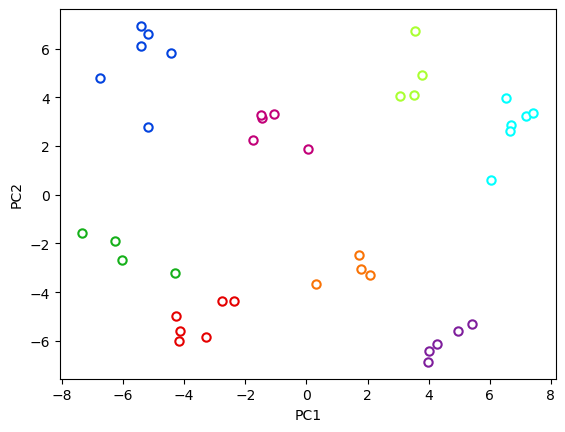

In [5]:
# Do PCA on the small data table and visualize them
data_small_param, data_small_type = read_table("w13-data-small.tbl")
data_small_pcs = PCA(data_small_param)[0]
visualize_data(data_small_pcs[:,:2],data_small_type, True)

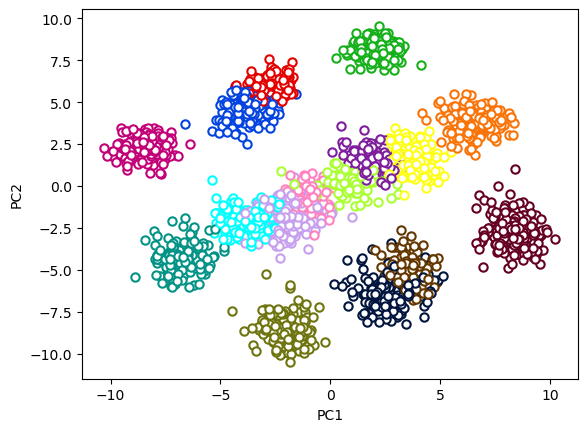

In [6]:
# Do PCA on the large data table and visualize
data_large_param, data_large_type = read_table("w13-data-large.tbl")
data_large_pcs = PCA(data_large_param)[0]
visualize_data(data_large_pcs[:,:2],data_large_type, True)

We see that PCA works fine for the small data table but the clusters does not look compact. For the large data table, we see that PCA is not clustering the data into their types. This might due to the fact that other than the first two PCs, there are other dimensions capturing the variances and resulting the variance between types not fully represented in the first two PCs.

# 2. Impliment t-SNE

We first select the sigma values following the below algorithm:
* We calculate the distance matrix between each data point.
* Then we calculate the probability in the original high-dimensional space.
* We implement the sigma objective which is the difference between the observed perplexity and target perplexity.
* Lastly we use `scipy.manfold.bisect` to minimize the objective and return the optimal sigmas.

In [7]:
def calc_distance_sq(data):
    """
    Calculate the squared distance between each data point.
    """
    data_rows = data.shape[0]
    dist = np.zeros((data_rows,data_rows))
    for i in range(data_rows):
        for j in range(data_rows):
            dist[i,j] = np.dot(data[i]-data[j],data[i]-data[j])
    return dist

def calc_p(sigma,d):
    """
    Calculate the probability based on the sigma and the distance
    """
    if d == 0: return 0
    return np.exp(-d/(2*np.square(sigma)))

def sigma_objective(sigma, target_perplexity, dist_vec):
    """
    The objective function to calculate the difference in observed
    perplexity and target perplexity.
    """
    p_vec = np.zeros(len(dist_vec))
    for i in range(len(dist_vec)):
        p_vec[i] = calc_p(sigma,dist_vec[i])
    p_vec = np.true_divide(p_vec,p_vec.sum())
    p_vec = p_vec[p_vec>0]
    h_vec = shannon_entropy(p_vec)
    obs_perplexity = 2**h_vec
    return obs_perplexity-target_perplexity

def shannon_entropy(p_vec):
    """
    Calculate the shannon entropy for the probability vector
    """
    return -np.sum(p_vec*np.log2(p_vec))

def calc_sigmas(data,perplexity,dist):
    """
    Compute the optimal sigmas from the data
    """
    data_rows = data.shape[0]
    sigmas = np.zeros(data_rows)
    for i in range(data_rows):
        a = 1
        b = 1
        while sigma_objective(a,perplexity,dist[i]) >= 0: a /= 2
        while sigma_objective(b,perplexity, dist[i]) <= 0: b *= 2
        sigmas[i] = bisect(sigma_objective,a,b,args=(perplexity,dist[i]))
    return sigmas


Next, we can compute the probability matrix. We implement the KL distance as the objective and the gradient calculation based on the algorithm on mcb112.org.

In [8]:
def cal_P(sigmas, dist):
    """
    Calculate the symmetric probability matrix
    """
    P_raw = np.zeros(dist.shape)
    for i in range(P_raw.shape[0]):
        for j in range(P_raw.shape[1]):
            P_raw[i,j] = calc_p(sigmas[i], dist[i,j])
    for i in range(P_raw.shape[0]):
        P_raw[i] = np.true_divide(P_raw[i],P_raw[i].sum())
    
    P = np.zeros(dist.shape)
    for i in range(P.shape[0]):
        for j in range(i,P.shape[1]):
            p_ij = P_raw[i,j]
            p_ji = P_raw[j,i]
            P[i,j] = (p_ij + p_ji)/(2*dist.shape[0])
            P[j,i] = P[i,j]
    return P

def calc_y(n):
    """
    Randomly initial Y from gaussian distribution.
    """
    return np.random.normal(0,10e-4,(n,2))

def KL_dist(Y,P):
    """
    Calculate the KL distance and gradients
    """
    n, m  = P.shape
    Y  = np.reshape(Y, (n,2))
    Y_dist = calc_distance_sq(Y)
    Q  = np.zeros(P.shape)
    for i in range(n):
        for j in range(m):
            if i != j:
                Q[i,j] = np.true_divide(1,(1+Y_dist[i,j]))
    Q = np.true_divide(Q,Q.sum())
    KL = 0
    for i in range(n):
        for j in range(m):
            if i != j:
                KL += P[i,j]*np.log(np.divide(P[i,j], Q[i,j]))

    gradients = np.zeros(Y.shape)
    for i in range(n):
        for j in range(m):
            gradients[i] += (P[i,j]-Q[i,j])*(Y[i]-Y[j])/(1+Y_dist[i,j])
    gradients *= 4
    return KL, gradients.flatten()


def tsne(data, perplexity):
    """
    Perform tsne and return the KL distance and optimal Y
    """
    dist = calc_distance_sq(data)
    sigmas = calc_sigmas(data,perplexity,dist)
    P = cal_P(sigmas,dist)
    Y = calc_y(dist.shape[0])
    result = optimize.minimize(KL_dist,Y.flatten(),args=(P),jac=True)
    return result.fun, result.x.reshape(Y.shape)

    

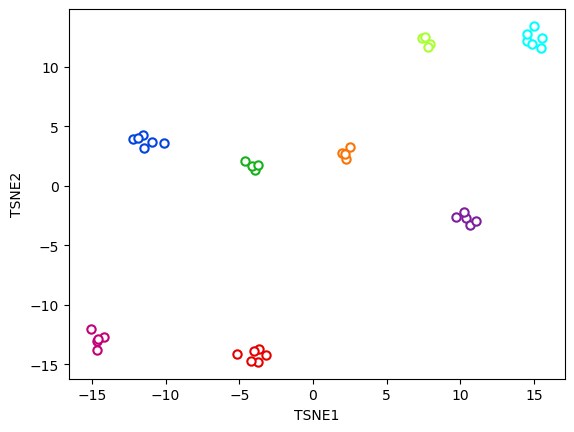

In [9]:
# Perform tsne for a couple times to avoid stuck at local minimal.
best_kl = None
best_y = None
for _ in range(5):
    res = tsne(data_small_param,5)
    if best_kl is None or best_kl > res[0]:
        best_kl = res[0]
        best_y = res[1]
visualize_data(best_y,data_small_type)

# 3. T-SNE from scikit

In [10]:
# Set the choices for the perplexity value
perplexity_choices = [2,5,30,100]

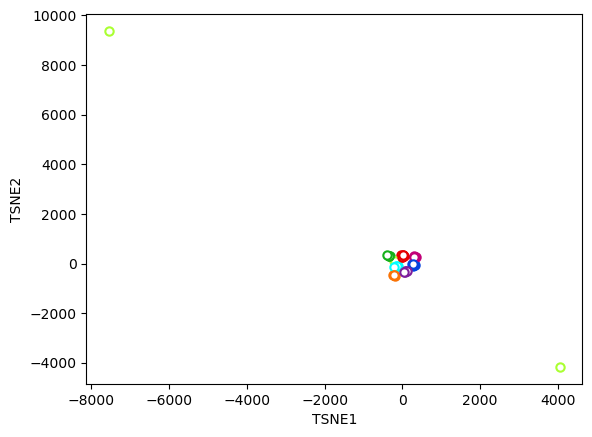

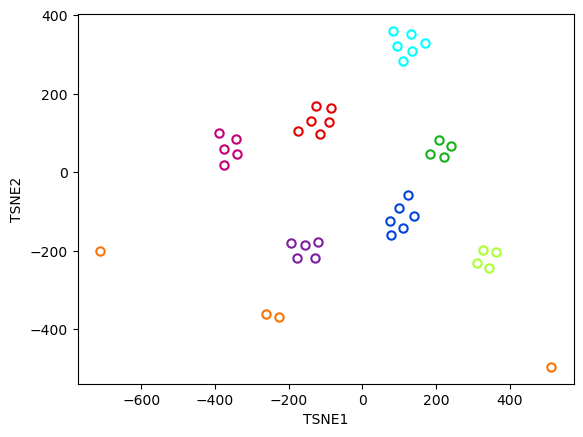

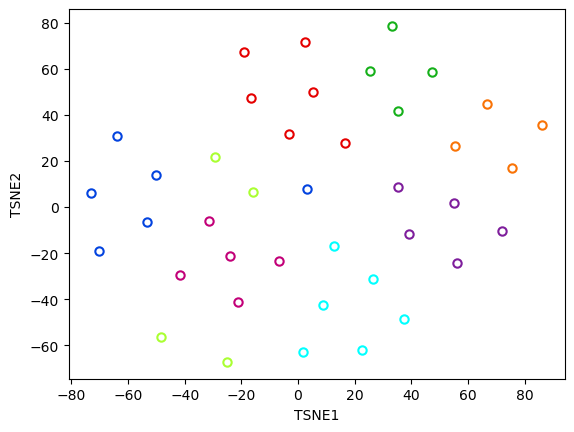

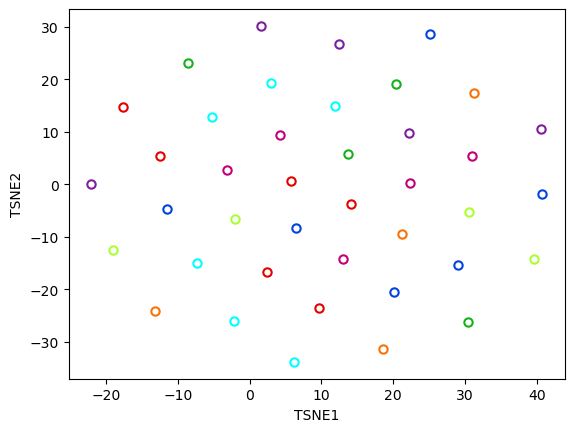

In [11]:
# Generate figures for the small data table
for p in perplexity_choices:
    data_small_tsne = TSNE(n_components=2,perplexity=p).fit_transform(data_small_param)
    visualize_data(data_small_tsne, data_small_type)

We have observed that for small perplexity scores like 2, the clustering is not obvious for the small data table. When the perplexity score is 5, the clustering is both clear and accurate. However, we observed that when the perplexity score continue to increase, the data points become sparse and the clustering is no longer apparent.

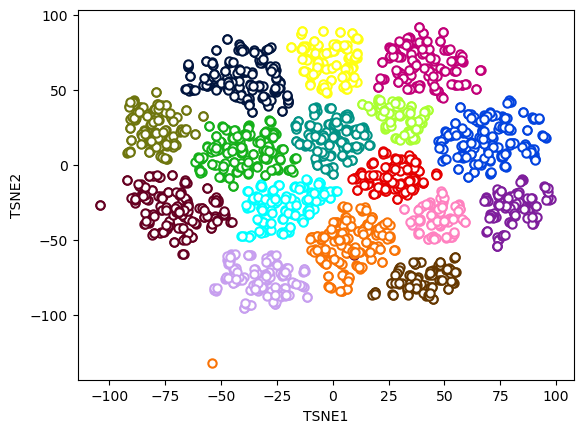

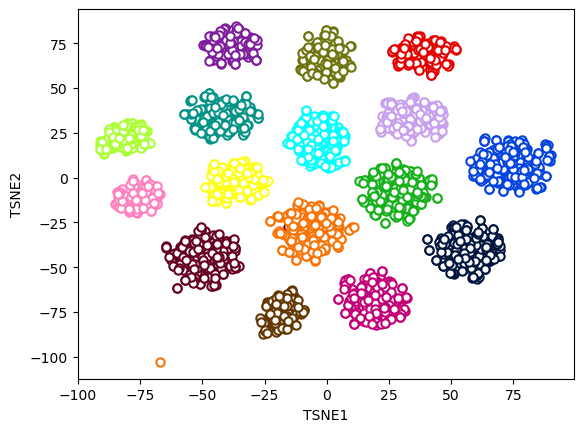

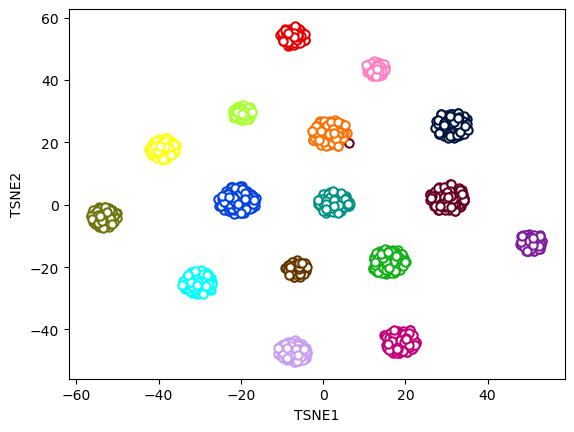

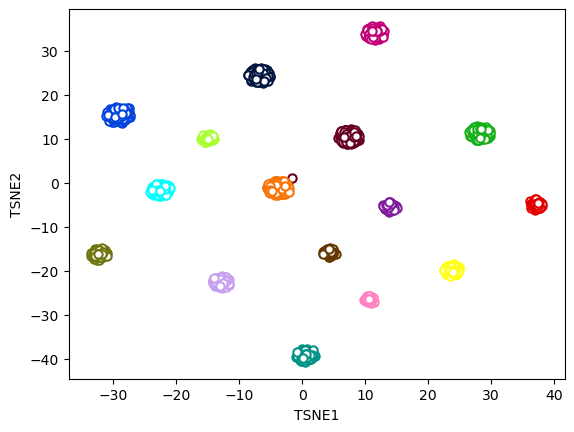

In [12]:
# Generate figures for the large data table
for p in perplexity_choices:
    data_large_tsne = TSNE(n_components=2,perplexity=p).fit_transform(data_large_param)
    visualize_data(data_large_tsne, data_large_type)

For the large data table, we observe that when the perplexity score increases, the clustering becomes more apparent and more compact while there are some error in the types vs clusters. We wonder if the reason we do not see sparse data points like we did for the smaller data set is because the perplexity score is large enough. 

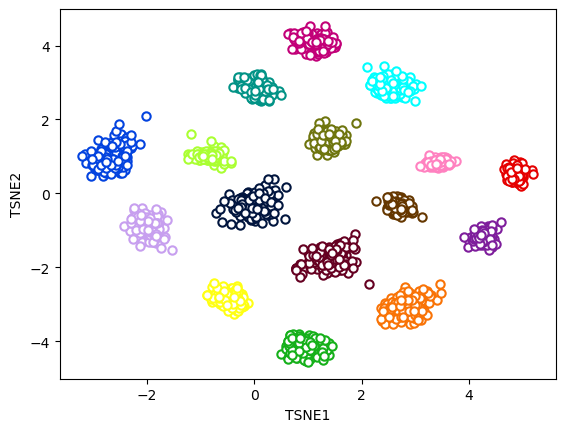

In [13]:
data_large_tsne = TSNE(n_components=2,perplexity=1000).fit_transform(data_large_param)
visualize_data(data_large_tsne, data_large_type)

We further increase the perplexity score to 1000. We see that the data points are not as compact as what we have observed when perplexity is 100 anymore. However, we do notice that the errors in clusterings for the types are gone so the accuracy of the clustering increases.

From what we have observed, there is complex relationship between the perplexity score and the sample size to achieve the optimal clustering results. 